In [10]:
import os
from TransformMNIST import MNISTtransformer
import subprocess
import sys
import caffe
import matplotlib
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def set_up_dir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

In [ ]:
src_lmdb_dir = '/mnt/antares_raid/home/oliver/adhara/src/caffe/examples/mnist/'
home_dir = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/'
set_up_dir(home_dir)
dst_lmdb_dir = home_dir + 'MNIST_lmdb/'
set_up_dir(dst_lmdb_dir)
N_ims = [60000, 10000]
angles = range(-90,90+1,15)
batch_size = 1000.
set_strings = ['_TRAIN_', '_TEST_']
dir_strings = ['_train_', '_test_']

if False:
    # Create the lmdb database
    for set_str, dir_str, N_im in zip(set_strings, dir_strings,N_ims):
        mnisttransform = MNISTtransformer(src_lmdb_dir, home_dir, dst_lmdb_dir, N_im, batch_size, set_str, dir_str, angles)
        mnisttransform.run()

In [ ]:
# Train autoencoder weights
#p = subprocess.Popen(["screen"])
#p = subprocess.Popen(["/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe", "train", "-solver", "/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/autoencoder_net_solver.prototxt"])

#/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe train -solver /mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/autoencoder_net_solver.prototxt 

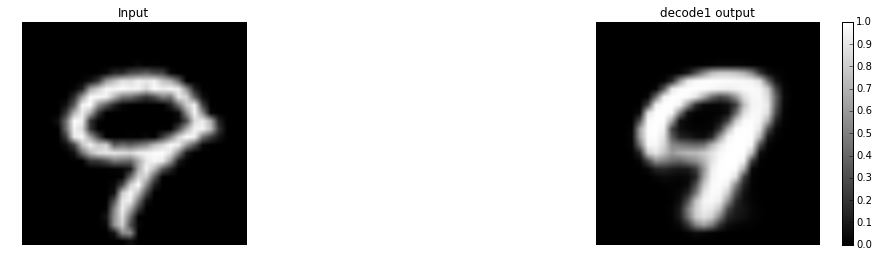

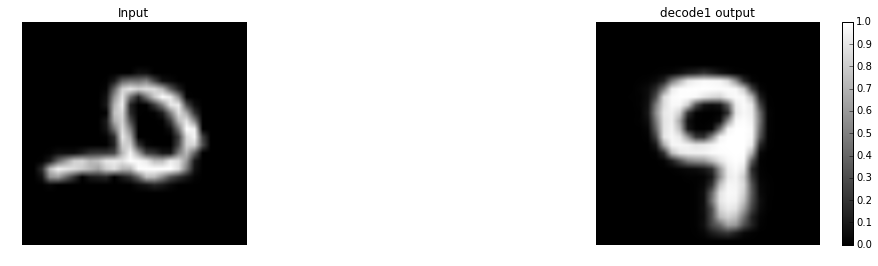

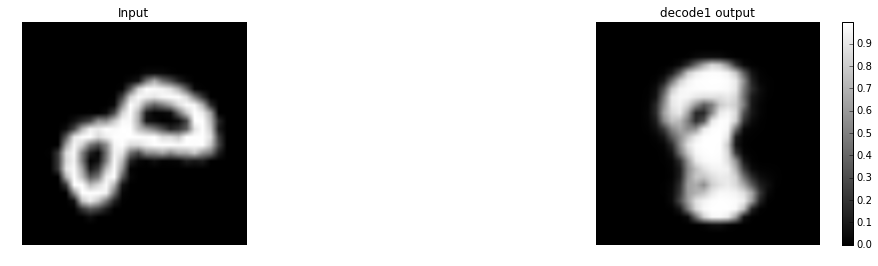

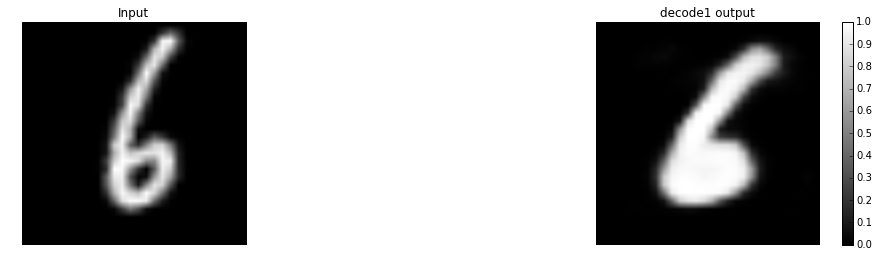

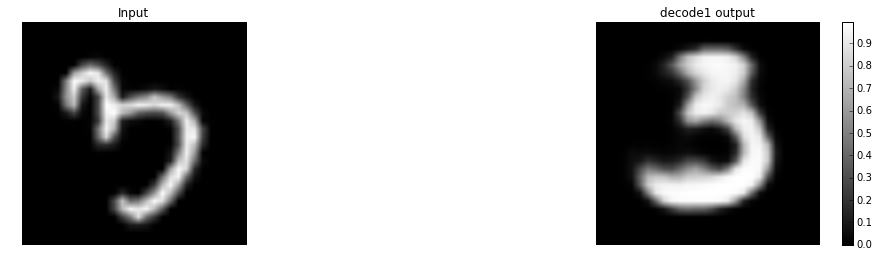


Confusion matrix:
(r , p) | count
(0 , 0) | 0
(0 , 9) | 0
(0 , 3) | 0
(0 , 6) | 0
(0 , 8) | 0
(9 , 0) | 2
(9 , 9) | 0
(9 , 3) | 0
(9 , 6) | 0
(9 , 8) | 0
(3 , 0) | 1
(3 , 9) | 0
(3 , 3) | 0
(3 , 6) | 0
(3 , 8) | 0
(6 , 0) | 1
(6 , 9) | 0
(6 , 3) | 0
(6 , 6) | 0
(6 , 8) | 0
(8 , 0) | 1
(8 , 9) | 0
(8 , 3) | 0
(8 , 6) | 0
(8 , 8) | 0


In [25]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))
# Check weights

proto = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/deploy_autoencoder_net.prototxt'
model = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/autoencoder/snapshots/_iter_156000.caffemodel'
lmdb_path = '/mnt/antares_raid/home/oliver/Scripts/autoencoder_v2/MNIST_lmdb/MNIST_TEST_10000_rot_lmdb/shuffled/'


count = 0
correct = 0
matrix = defaultdict(int) # (real,pred) -> int
labels_set = set()

net = caffe.Net(proto, model, caffe.TEST)
caffe.set_mode_cpu()
lmdb_env = lmdb.open(lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    label = int(datum.label)
    image = caffe.io.datum_to_array(datum)
    image = image.astype(np.uint8)
    
    out = net.forward_all(data=np.asarray([image]))
    plabel = int(out['score'][0].argmax(axis=0))

    count = count + 1
    iscorrect = label == plabel
    correct = correct + (1 if iscorrect else 0)
    matrix[(label, plabel)] += 1
    labels_set.update([label, plabel])

    #if not iscorrect:
    #    print("\rError: key=%s, expected %i but predicted %i" \
    #            % (key, label, plabel))

    #sys.stdout.write("\rAccuracy: %.1f%%" % (100.*correct/count))
    #sys.stdout.flush()
    
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    plt.imshow(image.reshape(28, 28).T, cmap='gray'); plt.axis('off')
    plt.title('Input')
    plt.subplot(1,2,2)
    plt.imshow(np.array([sigmoid(a) for a  in out['decode1'].squeeze()]).reshape(28, 28).T, cmap='gray'); plt.axis('off')
    plt.title('decode1 output')
    plt.colorbar()
    plt.show()

    if count == 5:
        break
#print(str(correct) + " out of " + str(count) + " were classified correctly")

print ""
print "Confusion matrix:"
print "(r , p) | count"
for l in labels_set:
    for pl in labels_set:
        print "(%i , %i) | %i" % (l, pl, matrix[(l,pl)])

In [ ]:
figure(figsize=(20,20))
imshow(solver.test_nets[0].blobs['data'].data[:15,:].reshape(15*28, 28).T, cmap='gray'); axis('off')
plt.title('TEST')
plt.show()
print( solver.test_nets[0].blobs['label'].data[:15])



plt.show()
figure(figsize=(20,20))

imshow(solver.test_nets[0].blobs['decode1neuron'].data[:15,:].reshape(15*28, 28).T, cmap='gray'); axis('off')
plt.title('TEST decoder output')
plt.show()
print( solver.test_nets[0].blobs['label'].data[:15])


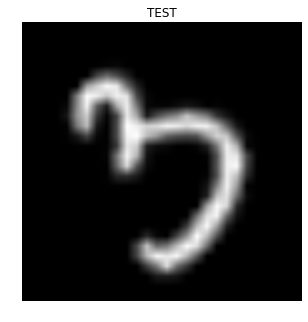

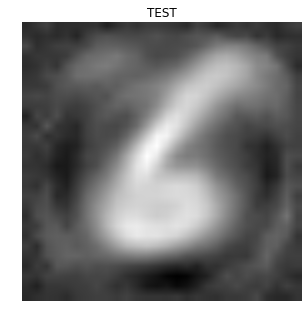

In [32]:
plt.figure(figsize=(5,5))
plt.imshow(image.reshape(28, 28).T, cmap='gray'); plt.axis('off')
plt.title('TEST')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(out['decode1'].reshape(28, 28).T, cmap='gray'); plt.axis('off')
plt.title('TEST')
plt.show()


In [23]:
np.array([sigmoid(a) for a  in out['decode1'].squeeze()]).shape

(784,)